In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set the drawing style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
# Define the data path
INPUT_PATH = '../data/processed/socialmedia_price_panel_6mo.csv'

def load_data(filepath):
    print(f"Loading data from: {filepath}")
    df = pd.read_csv(filepath)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df = df.sort_values('week_start')
    
    # Simple cleaning to ensure no NaN damages the drawing
    df_clean = df.dropna(subset=['mentions_week', 'sentiment_mean_w', 'weekly_volume', 'next_week_return', 'abnormal_volume'])
    print(f"Data Loaded. Shape: {df_clean.shape}")
    return df_clean

# Loading Data
df_clean = load_data(INPUT_PATH)
df_clean.head()

Loading data from: ../data/processed/socialmedia_price_panel_6mo.csv
Data Loaded. Shape: (190, 15)


,ticker,week_start,n_posts_week,n_comments_week,mentions_week,sentiment_mean_w,sentiment_score_weighted_w,median_compound_week,days_covered,weekly_close,weekly_volume,weekly_return,next_week_return,abnormal_volume,z_return
43,GME,2025-05-20,0.0,3.0,3.0,0.034233,0.034233,0.05135,2.0,33.029999,65485700.0,0.184295,-0.072358,2.259244,NaN
58,GOOG,2025-05-20,1.0,0.0,1.0,0.941300,0.941300,0.94130,1.0,169.235138,149118600.0,0.010246,0.004599,0.855547,NaN
1,AAPL,2025-05-20,0.0,15.0,15.0,0.018560,0.005890,0.00000,3.0,194.859741,226883700.0,-0.064709,0.032929,0.554979,NaN
186,WMT,2025-05-20,0.0,16.0,16.0,0.113119,0.008360,0.05135,3.0,96.115509,58732700.0,-0.018141,0.035603,-0.399546,NaN
120,NVDA,2025-05-20,1.0,0.0,1.0,0.962500,0.962500,0.96250,1.0,131.273483,818288200.0,-0.031570,0.046386,0.266054,NaN


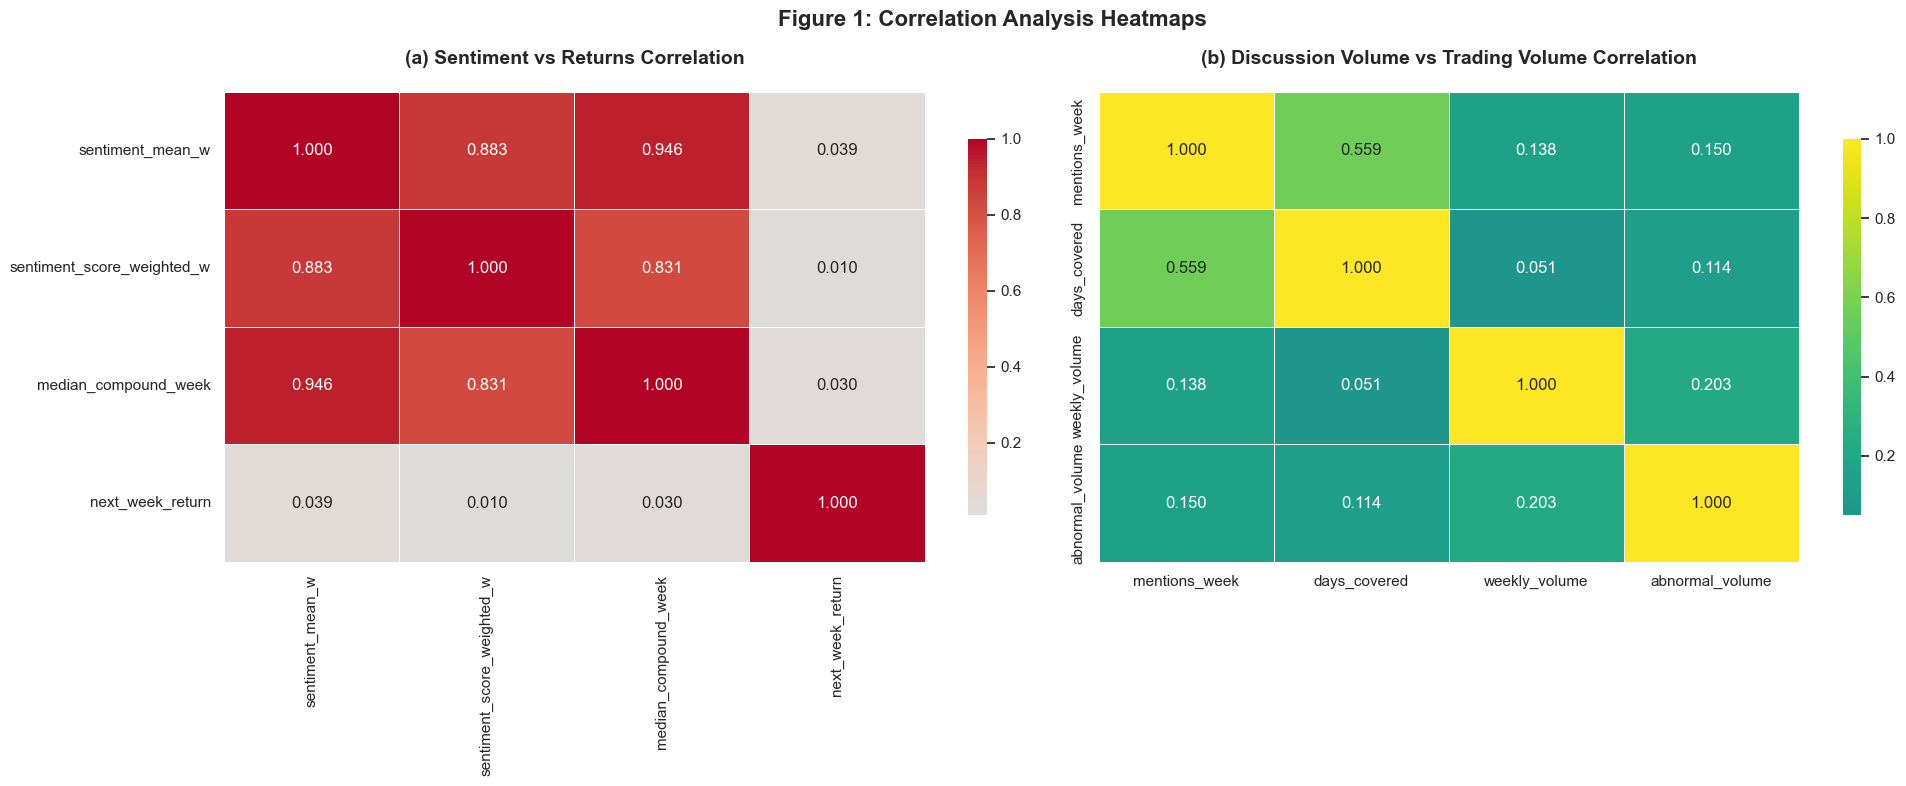

In [3]:
# Figure 1: Correlation Analysis Heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 1.1 Sentiment vs Returns
sentiment_corr_cols = ['sentiment_mean_w', 'sentiment_score_weighted_w', 'median_compound_week', 'next_week_return']
sentiment_corr_matrix = df_clean[sentiment_corr_cols].corr().round(3)
sns.heatmap(sentiment_corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt=".3f", linewidths=0.5, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('(a) Sentiment vs Returns Correlation', fontsize=14, fontweight='bold', pad=20)

# 1.2 Discussion Volume vs Trading Volume
volume_corr_cols = ['mentions_week', 'days_covered', 'weekly_volume', 'abnormal_volume']
volume_corr_matrix = df_clean[volume_corr_cols].corr().round(3)
sns.heatmap(volume_corr_matrix, annot=True, cmap='viridis', center=0, 
            fmt=".3f", linewidths=0.5, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('(b) Discussion Volume vs Trading Volume Correlation', fontsize=14, fontweight='bold', pad=20)

fig.suptitle('Figure 1: Correlation Analysis Heatmaps', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

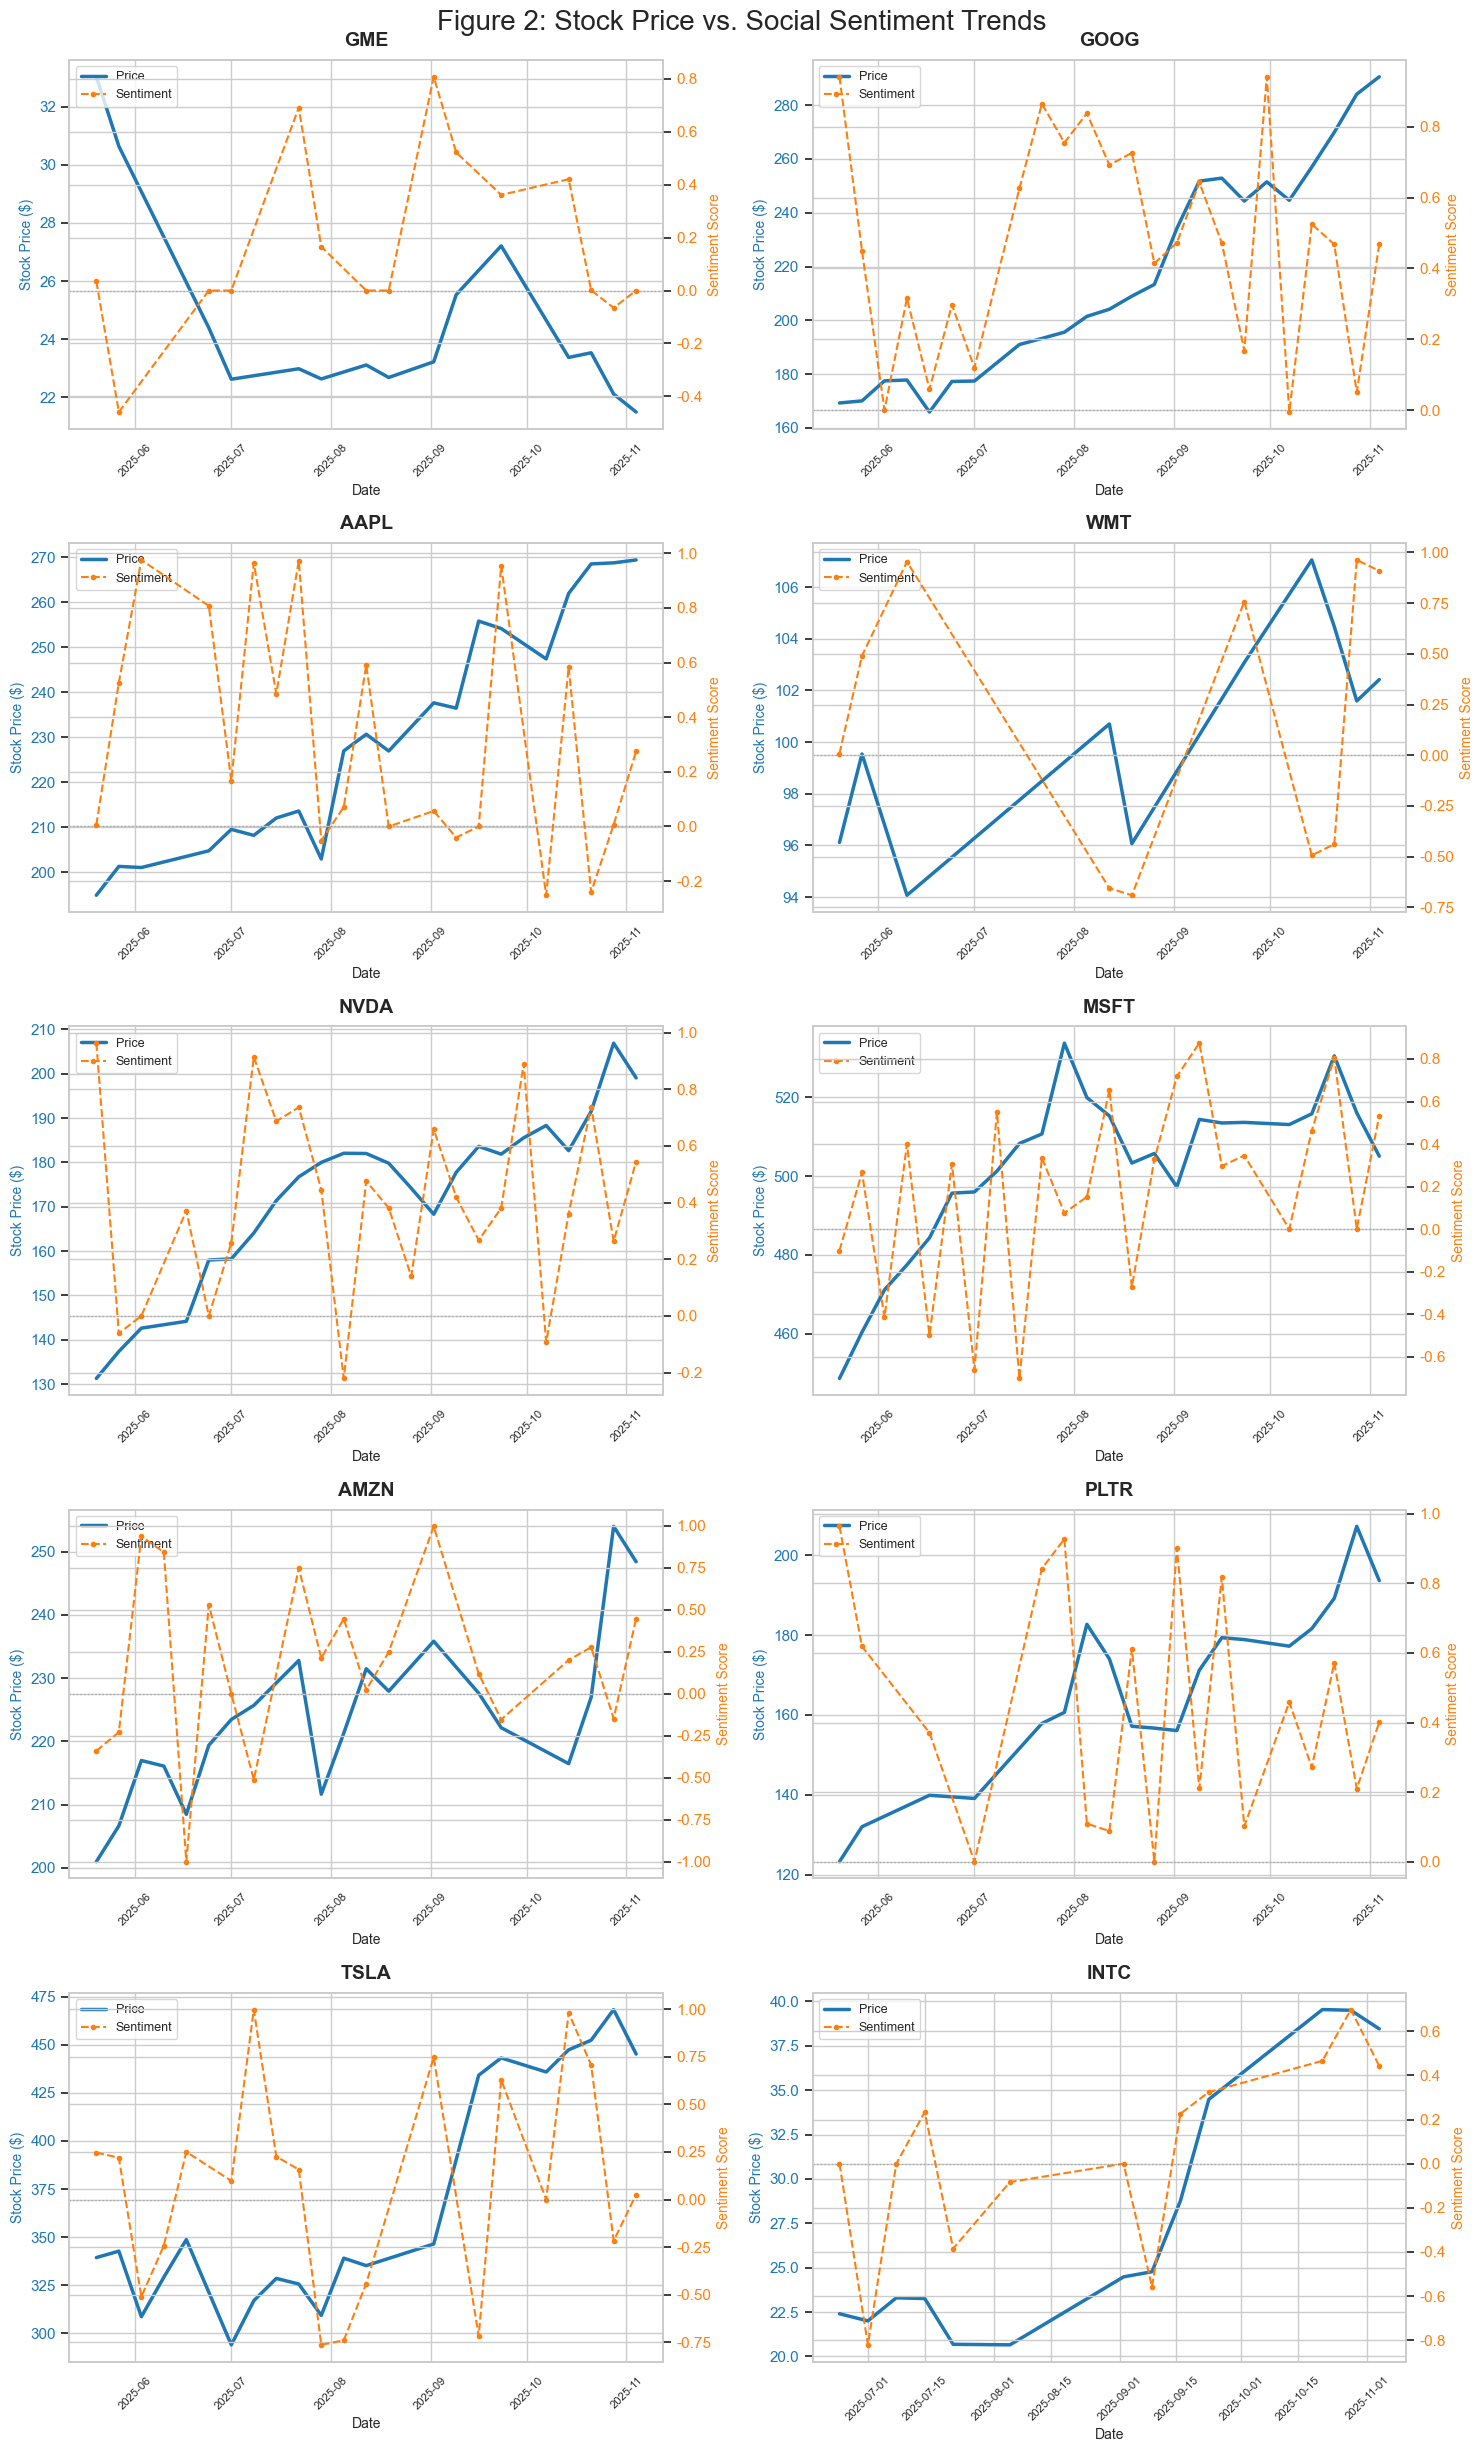

In [4]:
# Figure 2: Stock Price vs. Social Sentiment Trends
unique_tickers = df_clean['ticker'].unique()
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
fig.suptitle('Figure 2: Stock Price vs. Social Sentiment Trends', fontsize=20, y=0.98)

for idx, ticker in enumerate(unique_tickers):
    if idx >= rows * cols: break
    row = idx // cols
    col = idx % cols
    ticker_data = df_clean[df_clean['ticker'] == ticker].sort_values('week_start')
    
    ax1 = axes[row, col]
    # Stock Price (Left Axis)
    color1 = '#1f77b4'
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Stock Price ($)', color=color1, fontsize=10)
    ax1.plot(ticker_data['week_start'], ticker_data['weekly_close'], color=color1, linewidth=2.5, label='Price')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Sentiment Score (Right Axis)
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'
    ax2.set_ylabel('Sentiment Score', color=color2, fontsize=10)
    ax2.plot(ticker_data['week_start'], ticker_data['sentiment_score_weighted_w'], color=color2, linestyle='--', marker='o', markersize=3, linewidth=1.5, label='Sentiment')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    ax1.set_title(f'{ticker}', fontsize=14, fontweight='bold', pad=10)
    
    # Combined Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

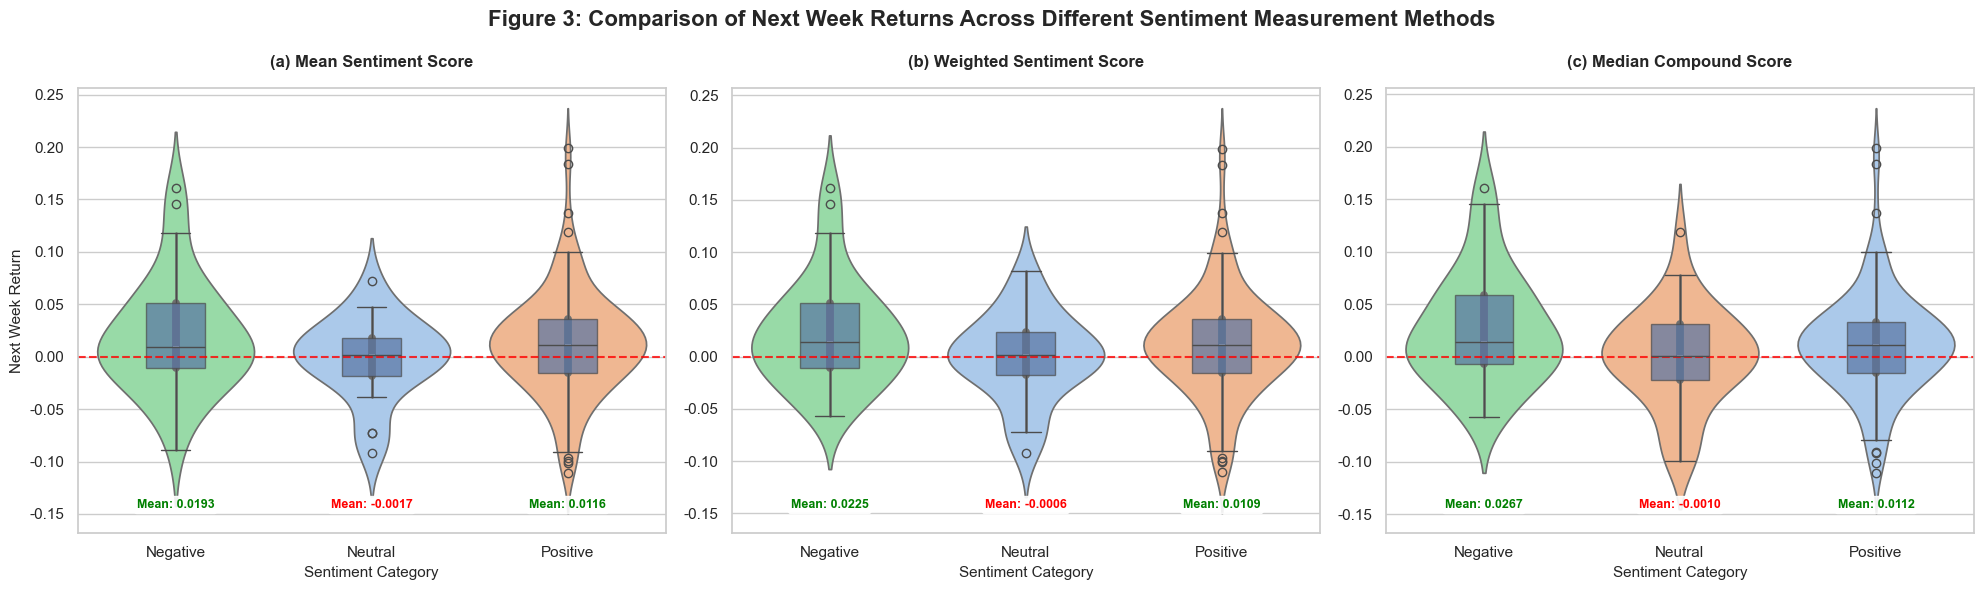

In [5]:
# Figure 3: Sentiment Score vs. Next Week Returns
def get_sentiment_label(score):
    if score > 0.05: return 'Positive'
    if score < -0.05: return 'Negative'
    return 'Neutral'

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Figure 3: Comparison of Next Week Returns Across Different Sentiment Measurement Methods', fontsize=16, fontweight='bold', y=0.98)

sentiment_metrics = ['sentiment_mean_w', 'sentiment_score_weighted_w', 'median_compound_week']
titles = ['Mean Sentiment Score', 'Weighted Sentiment Score', 'Median Compound Score']

for idx, (metric, title) in enumerate(zip(sentiment_metrics, titles)):
    temp_df = df_clean.copy()
    temp_df['sentiment_label'] = temp_df[metric].apply(get_sentiment_label)   
    
    # Violin + Box Plot
    sns.violinplot(x='sentiment_label', y='next_week_return', hue='sentiment_label', data=temp_df, order=['Negative', 'Neutral', 'Positive'], palette='pastel', ax=axes[idx])
    sns.boxplot(x='sentiment_label', y='next_week_return', data=temp_df, order=['Negative', 'Neutral', 'Positive'], width=0.3, boxprops={'alpha': 0.7}, ax=axes[idx])
    axes[idx].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='Zero Return')

    # Add Mean Labels
    means = temp_df.groupby('sentiment_label')['next_week_return'].mean()
    for i, category in enumerate(['Negative', 'Neutral', 'Positive']):
        if category in means:
            mean_val = means[category]
            color = 'green' if mean_val > 0 else 'red' if mean_val < 0 else 'black'
            axes[idx].text(i, axes[idx].get_ylim()[0] + (axes[idx].get_ylim()[1] - axes[idx].get_ylim()[0]) * 0.05, 
                        f'Mean: {mean_val:.4f}', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold', color=color,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.9))
    
    axes[idx].set_title(f'({chr(97+idx)}) {title}', fontsize=12, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Sentiment Category', fontsize=11)
    if idx == 0: axes[idx].set_ylabel('Next Week Return', fontsize=11)
    else: axes[idx].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

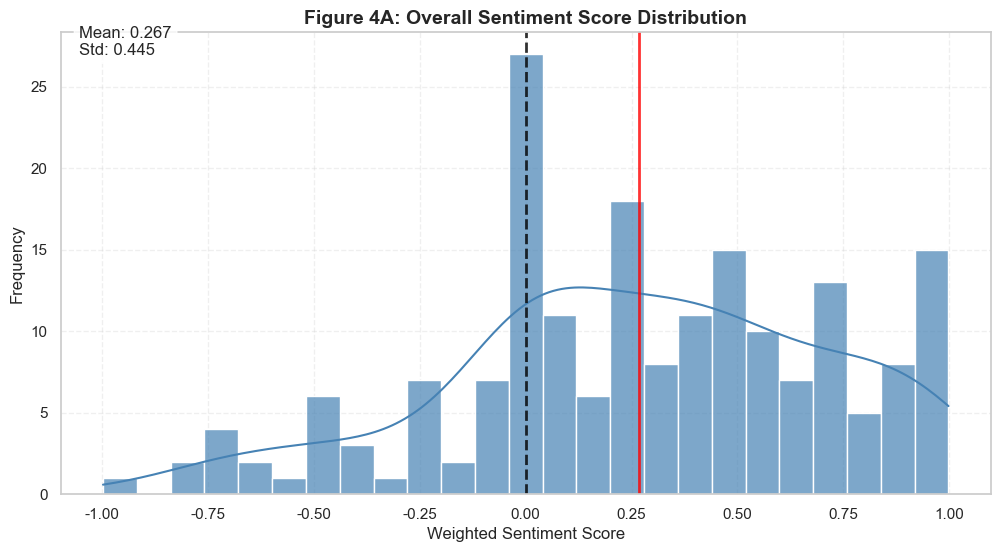

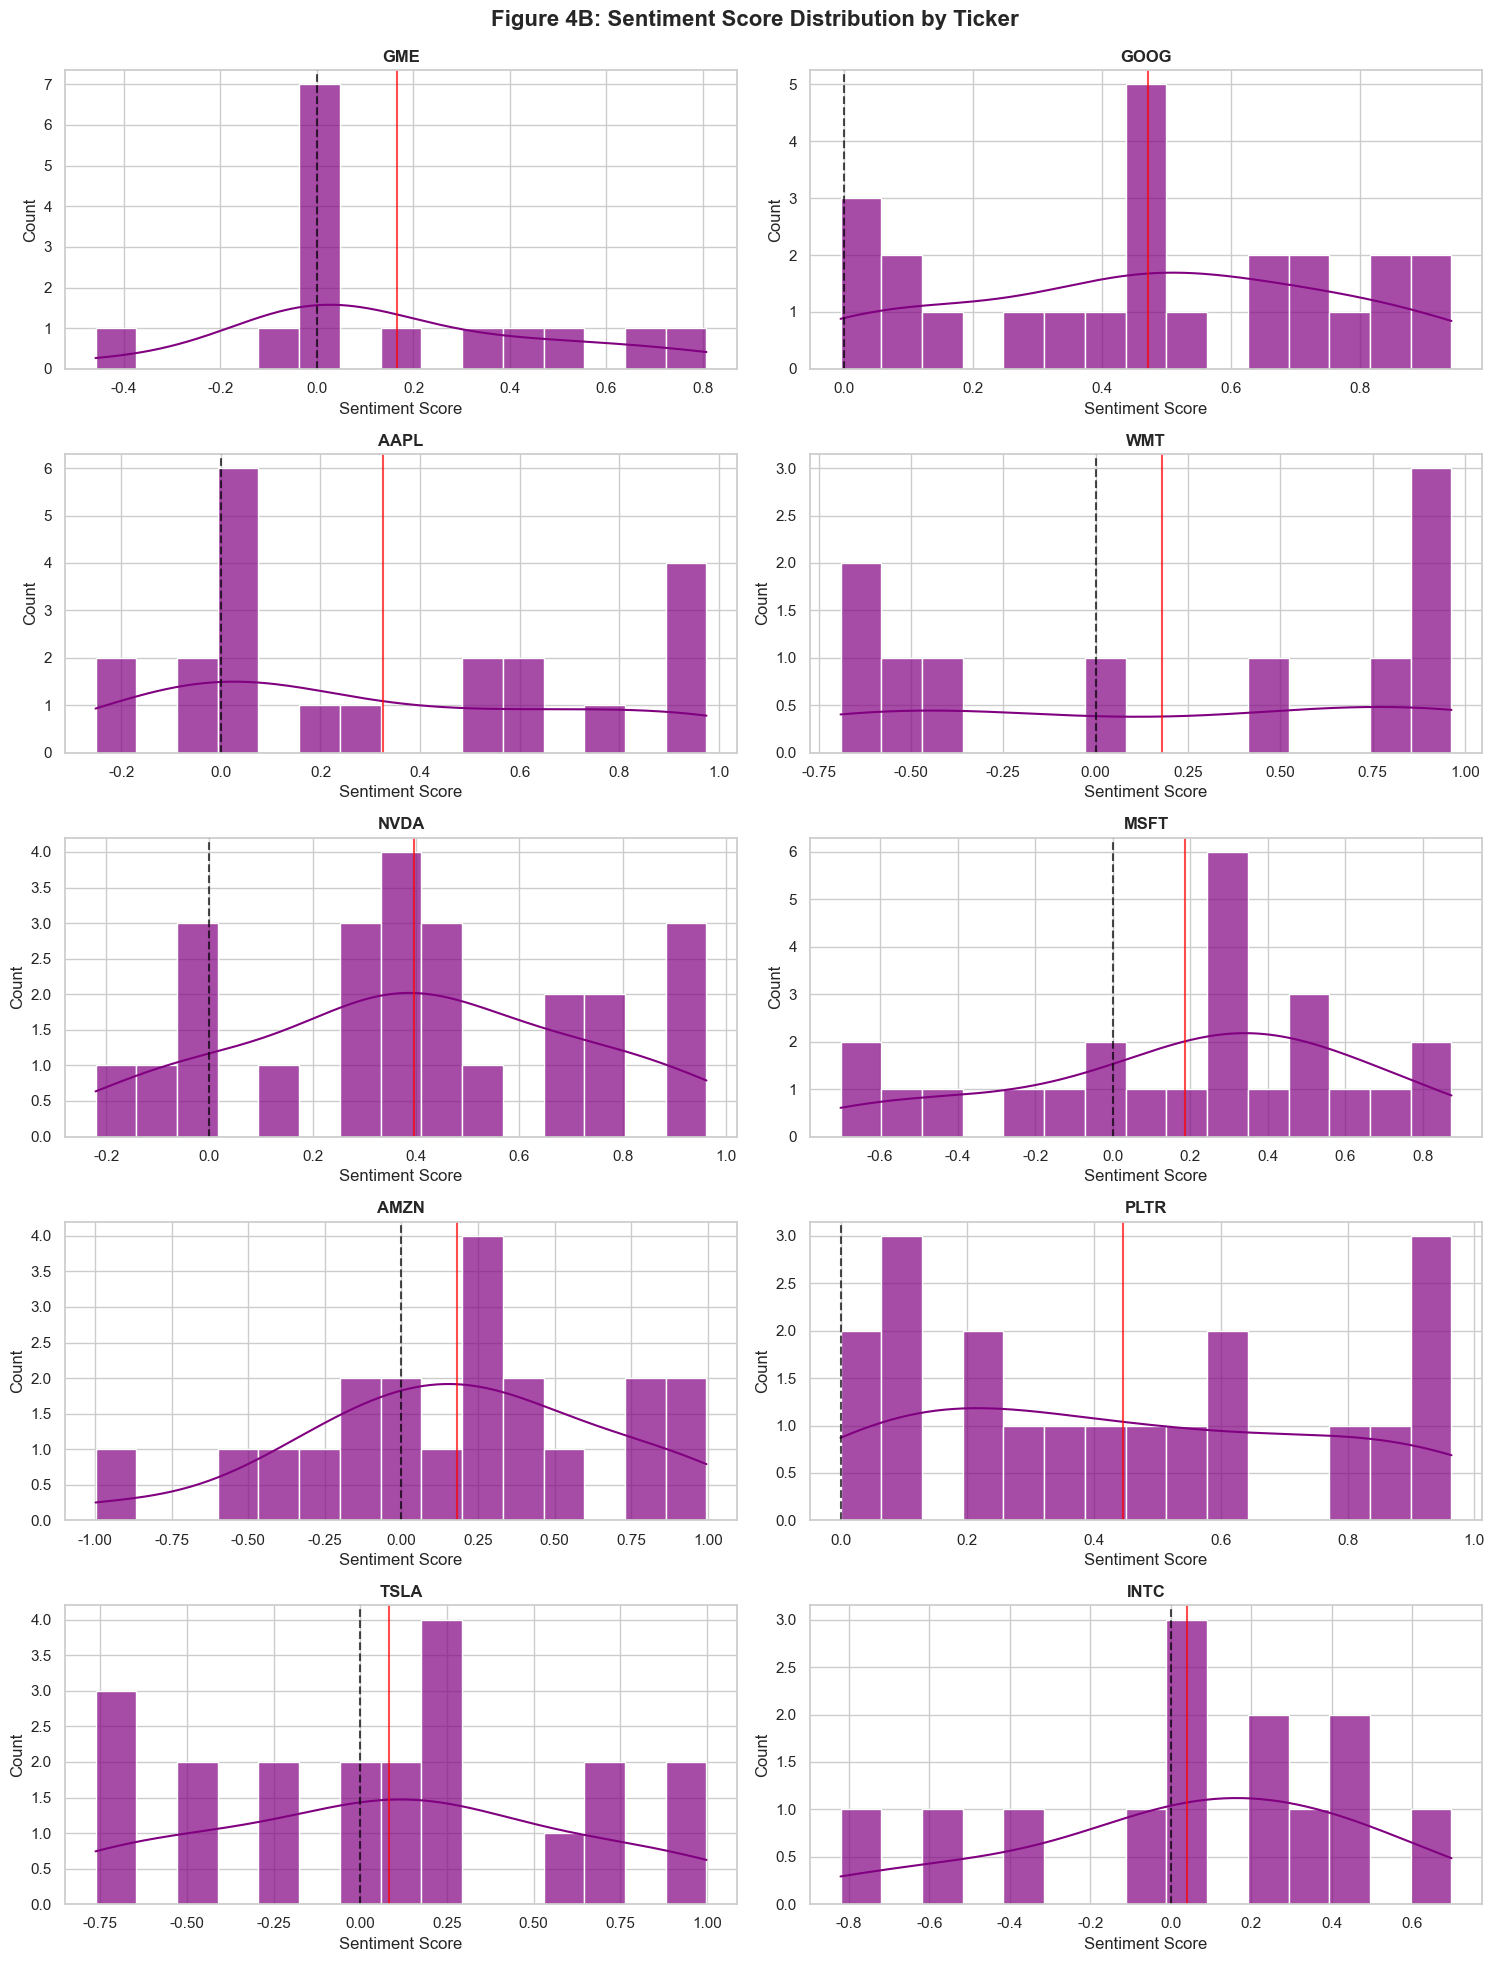

In [6]:
# Figure 4A: Overall Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(x=df_clean['sentiment_score_weighted_w'], bins=25, kde=True, color='steelblue', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(df_clean['sentiment_score_weighted_w'].mean(), color='red', linestyle='-', linewidth=2, alpha=0.8)

mean_val = df_clean['sentiment_score_weighted_w'].mean()
std_val = df_clean['sentiment_score_weighted_w'].std()
plt.title('Figure 4A: Overall Sentiment Score Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Weighted Sentiment Score')
plt.ylabel('Frequency')

# Annotate Stats
plt.text(0.02, 0.95, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}', 
        transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# Figure 4B: Per Ticker Distribution
unique_tickers = df_clean['ticker'].unique()
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))

for idx, ticker in enumerate(unique_tickers):
    if idx >= rows * cols: break
    row = idx // cols
    col = idx % cols
    ticker_data = df_clean[df_clean['ticker'] == ticker]
    ax = axes[row, col]
    
    sns.histplot(ticker_data['sentiment_score_weighted_w'], bins=15, kde=True, color='purple', alpha=0.7, ax=ax)
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(ticker_data['sentiment_score_weighted_w'].mean(), color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    
    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sentiment Score')

plt.suptitle('Figure 4B: Sentiment Score Distribution by Ticker', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

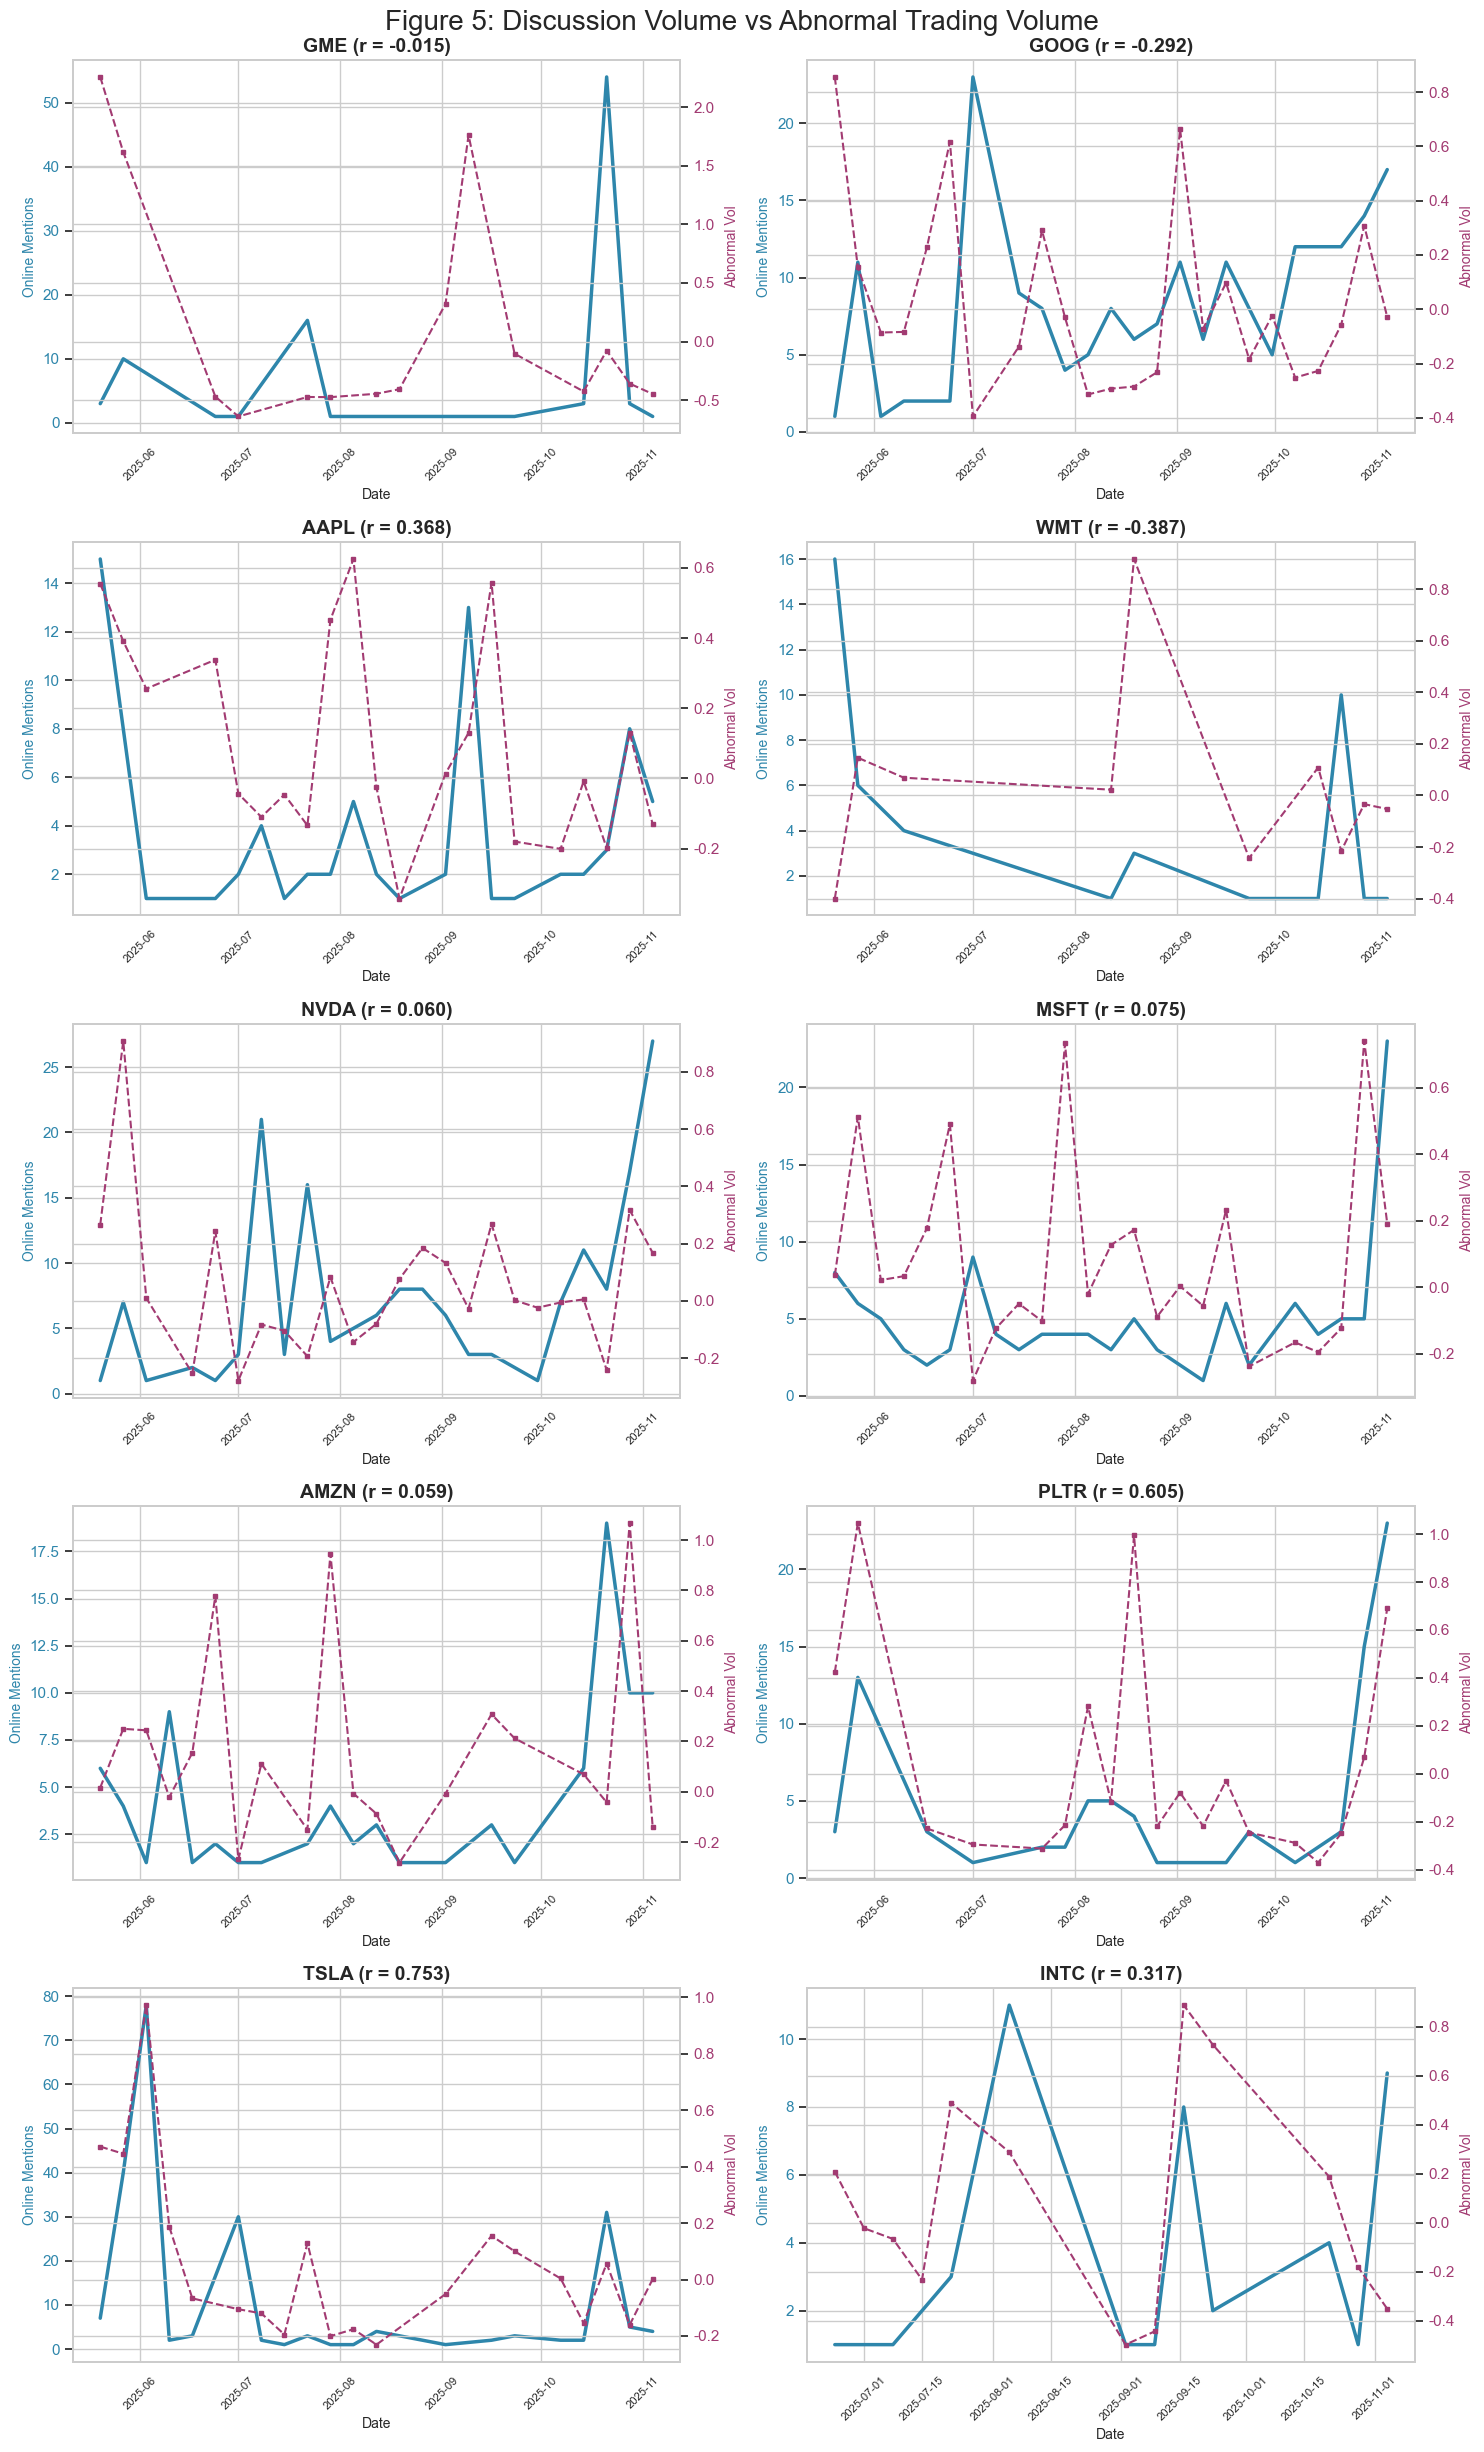

In [7]:
# Figure 5: Online Discussion Volume vs. Abnormal Trading Volume (Time Series)
unique_tickers = df_clean['ticker'].unique()
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 25))
fig.suptitle('Figure 5: Discussion Volume vs Abnormal Trading Volume', fontsize=20, y=0.98)

for idx, ticker in enumerate(unique_tickers):
    if idx >= rows * cols: break
    row = idx // cols
    col = idx % cols
    ticker_data = df_clean[df_clean['ticker'] == ticker].sort_values('week_start')
    ax1 = axes[row, col]
    
    # Mentions
    color1 = '#2E86AB'
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Online Mentions', color=color1, fontsize=10)
    ax1.plot(ticker_data['week_start'], ticker_data['mentions_week'], color=color1, linewidth=2.5, label='Mentions')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Abnormal Volume
    ax2 = ax1.twinx()
    color2 = '#A23B72'
    ax2.set_ylabel('Abnormal Vol', color=color2, fontsize=10)
    ax2.plot(ticker_data['week_start'], ticker_data['abnormal_volume'], color=color2, linestyle='--', marker='s', markersize=3, label='Abn Vol')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    corr = ticker_data['mentions_week'].corr(ticker_data['abnormal_volume'])
    ax1.set_title(f'{ticker} (r = {corr:.3f})', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

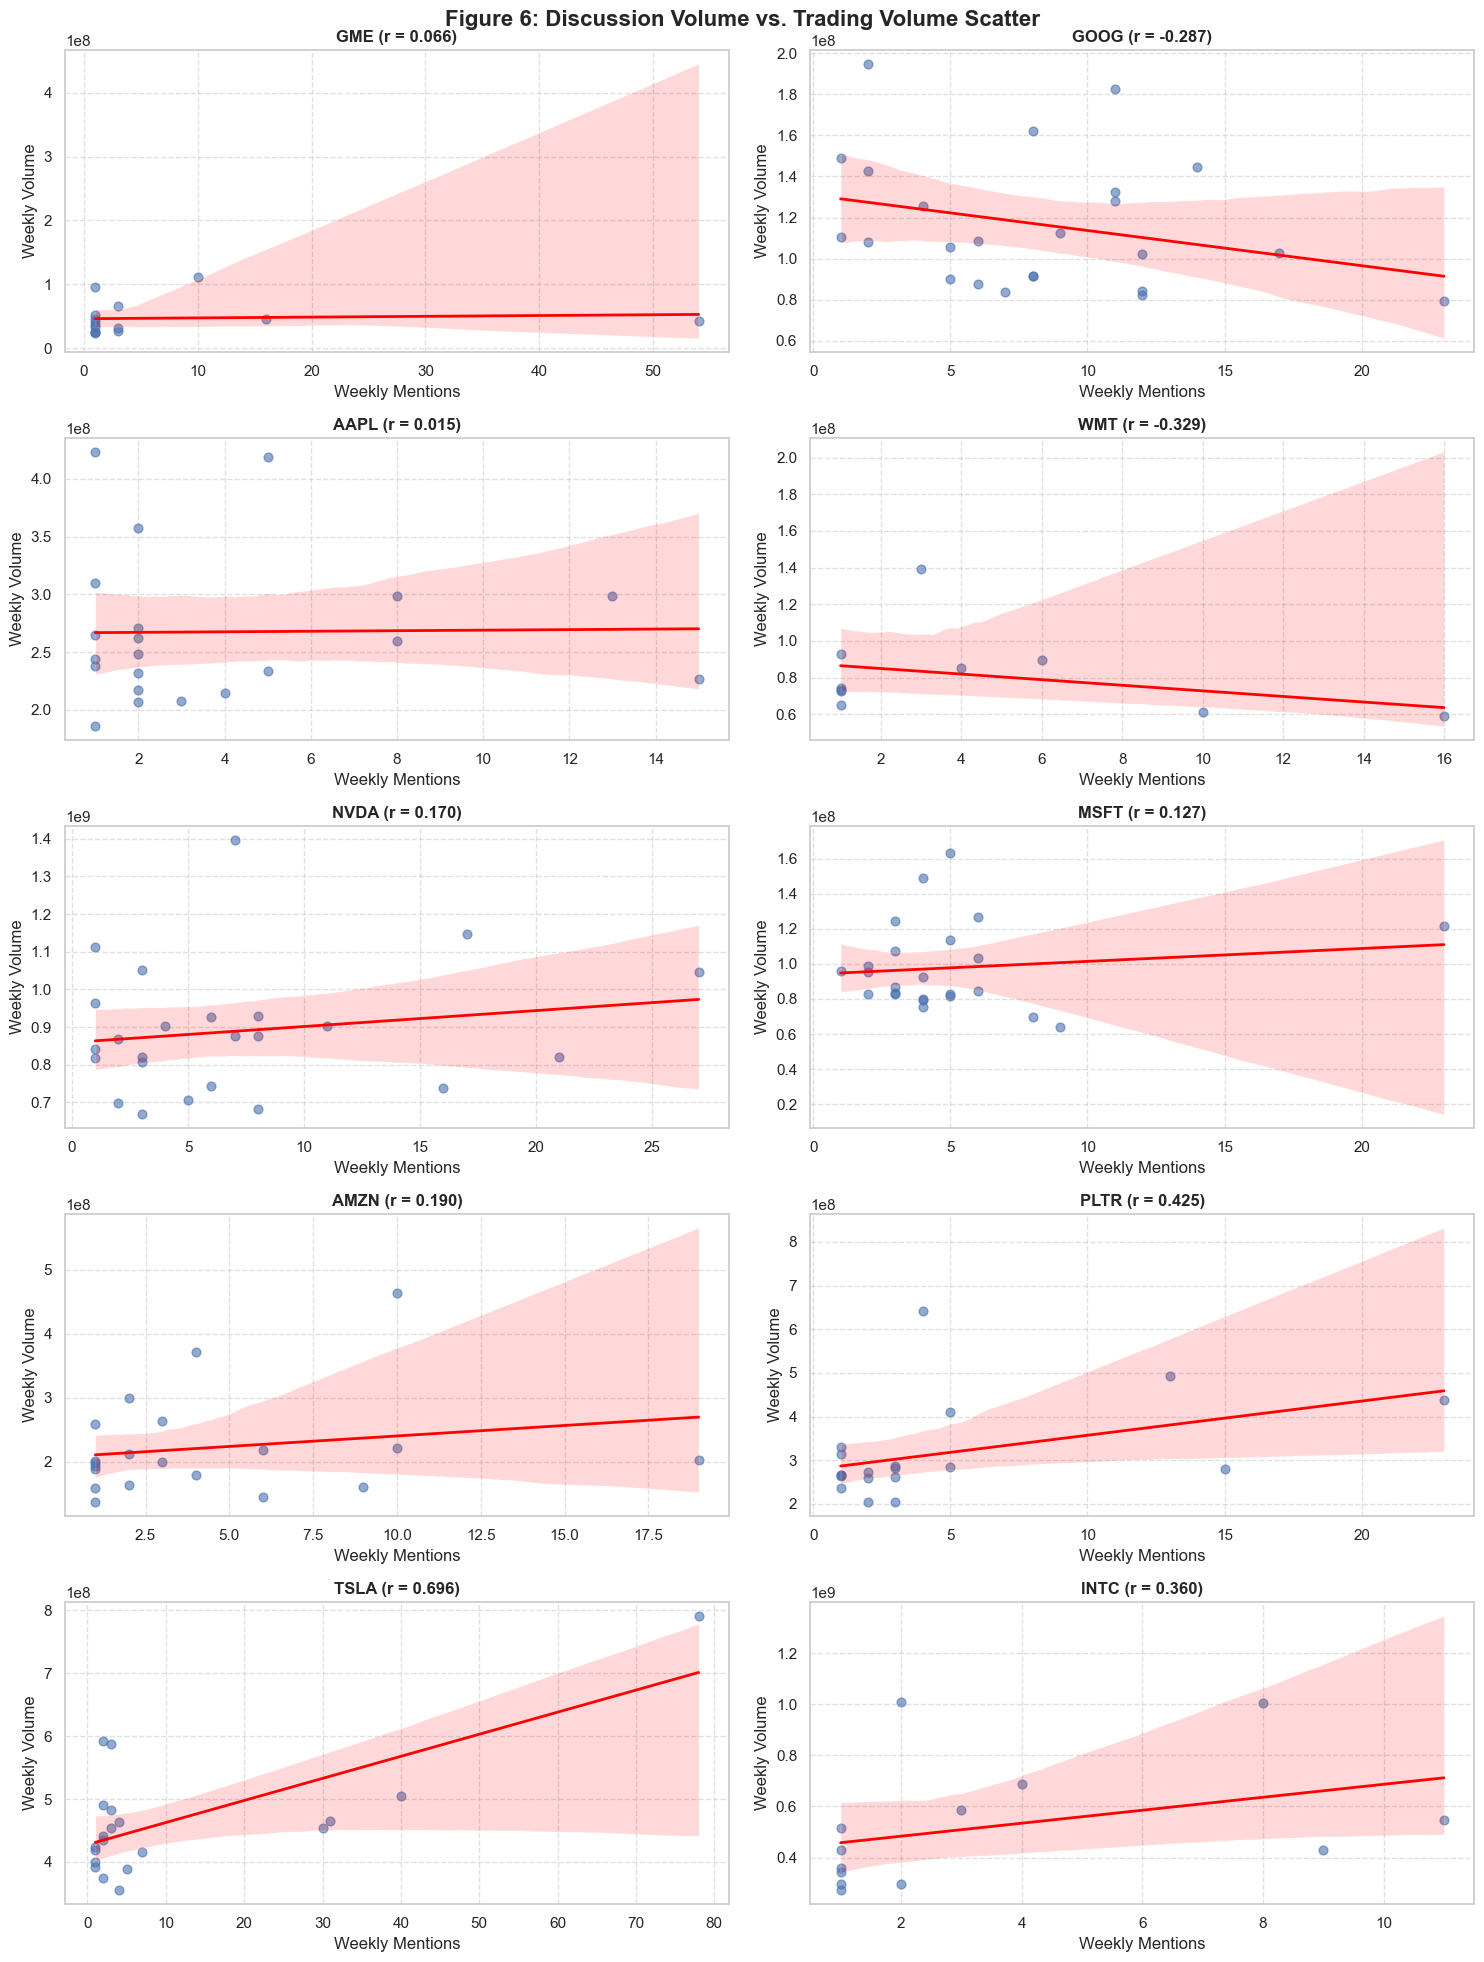

In [8]:
# Figure 6: Scatter Plot with Regression Line
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
fig.suptitle('Figure 6: Discussion Volume vs. Trading Volume Scatter', fontsize=16, fontweight='bold', y=0.98)

for idx, ticker in enumerate(unique_tickers):
    if idx >= rows * cols: break
    row = idx // cols
    col = idx % cols
    ticker_data = df_clean[df_clean['ticker'] == ticker]
    ax = axes[row, col]
    
    sns.regplot(x='mentions_week', y='weekly_volume', data=ticker_data, 
                scatter_kws={'alpha':0.6, 's':40}, line_kws={'color':'red', 'linewidth':2}, ax=ax)
    
    corr = ticker_data['mentions_week'].corr(ticker_data['weekly_volume'])
    ax.set_title(f'{ticker} (r = {corr:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Weekly Mentions')
    ax.set_ylabel('Weekly Volume')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()